# 📊 Restaurant Orders ML Pipeline (Colab Ready)

This notebook lets you:
1. Load restaurant orders dataset (CSV or GitHub link).
2. Build features + 30-day return label.
3. Train Decision Tree & Naive Bayes.
4. Evaluate metrics and generate graphs.
5. Compare scalability and save artifacts.

In [18]:
!pip install pandas numpy scikit-learn joblib matplotlib seaborn memory_profiler

In [19]:
# Load dataset from GitHub or upload CSV
import pandas as pd

url = 'https://raw.githubusercontent.com/avinash972/restaurant-dw-ml/main/restaurant_orders.csv'
df_orders = pd.read_csv(url, parse_dates=['timestamp'])
print('Rows loaded:', len(df_orders))
df_orders.head()

Rows loaded: 2000


,order_id,customer_id,timestamp,total_amount,num_items,status,channel
0,1,CUST110,2024-11-18 22:34:00,1169.93,4,completed,delivery
1,2,CUST098,2024-04-06 11:47:00,875.42,7,completed,dine-in
2,3,CUST079,2024-09-10 14:32:00,1248.72,2,completed,dine-in
3,4,CUST040,2024-11-18 14:47:00,1323.64,1,completed,delivery
4,5,CUST093,2024-06-29 16:33:00,1361.23,7,completed,dine-in


In [20]:
# Feature Engineering + 90-day frequency
import numpy as np
orders = df_orders.copy()
orders = orders.sort_values(['customer_id','timestamp']).reset_index(drop=True)

# Label: return within 30 days
comp = orders[orders['status'] == 'completed'].sort_values(['customer_id','timestamp']).reset_index(drop=True)
comp['next_ts'] = comp.groupby('customer_id')['timestamp'].shift(-1)
comp['days_to_next'] = (comp['next_ts'] - comp['timestamp']).dt.days
comp['return_30d'] = ((comp['days_to_next'].notna()) & (comp['days_to_next'] <= 30)).astype(int)
label_map = comp.set_index('order_id')['return_30d'].to_dict()
orders['return_30d'] = orders['order_id'].map(label_map).fillna(0).astype(int)

# Features
orders['prev_ts'] = orders.groupby('customer_id')['timestamp'].shift(1)
orders['recency_days'] = (orders['timestamp'] - orders['prev_ts']).dt.days.fillna(999).astype(int)
orders['avg_ticket'] = orders['total_amount'] / orders['num_items'].replace(0,1)
orders['order_hour'] = orders['timestamp'].dt.hour
orders['is_weekend'] = orders['timestamp'].dt.dayofweek.isin([5,6]).astype(int)

# 90-day frequency
freq90 = []
for idx, row in orders.iterrows():
    cust = row['customer_id']
    ts = row['timestamp']
    prior = orders[(orders['customer_id'] == cust) &
                   (orders['timestamp'] < ts) &
                   (orders['timestamp'] >= ts - pd.Timedelta(days=90)) &
                   (orders['status'] == 'completed')]
    freq90.append(len(prior))
orders['freq_90d'] = freq90

# Modeling dataset
model_df = orders[orders['status'] == 'completed'].copy()
print('Model dataset rows:', len(model_df))
model_df.head()

Model dataset rows: 1796


,order_id,customer_id,timestamp,total_amount,num_items,status,channel,return_30d,prev_ts,recency_days,avg_ticket,order_hour,is_weekend,freq_90d
0,1463,CUST001,2024-01-15 10:45:00,1259.29,7,completed,dine-in,1,NaT,999,179.898571,10,0,0
1,1761,CUST001,2024-01-21 15:55:00,793.07,5,completed,delivery,0,2024-01-15 10:45:00,6,158.614000,15,1,1
2,228,CUST001,2024-03-05 18:26:00,1475.97,3,completed,dine-in,1,2024-01-21 15:55:00,44,491.990000,18,0,2
3,1088,CUST001,2024-03-17 16:37:00,1379.80,1,completed,dine-in,1,2024-03-05 18:26:00,11,1379.800000,16,1,3
4,238,CUST001,2024-03-31 11:38:00,889.85,4,completed,takeaway,1,2024-03-17 16:37:00,13,222.462500,11,1,4


In [21]:
# Train & Evaluate Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import joblib, os, matplotlib.pyplot as plt, seaborn as sns

# Train/test split
split_date = pd.to_datetime('2024-07-01')
train = model_df[model_df['timestamp'] < split_date].copy()
test = model_df[model_df['timestamp'] >= split_date].copy()

feature_cols = ['total_amount','num_items','recency_days','avg_ticket','order_hour','is_weekend','freq_90d']
train = pd.get_dummies(train, columns=['channel'], drop_first=True)
test = pd.get_dummies(test, columns=['channel'], drop_first=True)
for c in ['channel_takeaway','channel_delivery']:
    if c not in train.columns: train[c]=0
    if c not in test.columns: test[c]=0
feature_cols += ['channel_takeaway','channel_delivery']

X_train, y_train = train[feature_cols].fillna(0), train['return_30d']
X_test, y_test = test[feature_cols].fillna(0), test['return_30d']

# Train models
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state=42)
nb = GaussianNB()

dt.fit(X_train, y_train)
nb.fit(X_train, y_train)

# Predictions
y_dt, y_nb = dt.predict(X_test), nb.predict(X_test)
p_dt, p_nb = dt.predict_proba(X_test)[:,1], nb.predict_proba(X_test)[:,1]

# Metrics function
def metrics(y_true, y_pred, y_proba):
    return dict(
        accuracy = round(accuracy_score(y_true, y_pred),3),
        precision = round(precision_score(y_true, y_pred, zero_division=0),3),
        recall = round(recall_score(y_true, y_pred, zero_division=0),3),
        f1 = round(f1_score(y_true, y_pred, zero_division=0),3),
        roc_auc = round(roc_auc_score(y_true, y_proba) if len(set(y_true))>1 else float('nan'),3)
    )

dt_metrics = metrics(y_test, y_dt, p_dt)
nb_metrics = metrics(y_test, y_nb, p_nb)

print('Decision Tree:', dt_metrics)
print('Naive Bayes:', nb_metrics)

print('\nClassification Report (Decision Tree):\n', classification_report(y_test, y_dt, zero_division=0))
print('\nClassification Report (Naive Bayes):\n', classification_report(y_test, y_nb, zero_division=0))

Decision Tree: {'accuracy': 0.65, 'precision': 0.659, 'recall': 0.976, 'f1': 0.787, 'roc_auc': np.float64(0.506)}
Naive Bayes: {'accuracy': 0.658, 'precision': 0.661, 'recall': 0.991, 'f1': 0.793, 'roc_auc': np.float64(0.487)}

Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.22      0.01      0.03       295
           1       0.66      0.98      0.79       576

    accuracy                           0.65       871
   macro avg       0.44      0.49      0.41       871
weighted avg       0.51      0.65      0.53       871


Classification Report (Naive Bayes):
               precision    recall  f1-score   support

           0       0.29      0.01      0.01       295
           1       0.66      0.99      0.79       576

    accuracy                           0.66       871
   macro avg       0.47      0.50      0.40       871
weighted avg       0.53      0.66      0.53       871



In [22]:
# Save models and dataset
os.makedirs('outputs', exist_ok=True)
joblib.dump(dt, 'outputs/decision_tree.joblib')
joblib.dump(nb, 'outputs/naive_bayes.joblib')
model_df.to_csv('outputs/model_dataset.csv', index=False)
print('Artifacts saved in outputs/')

Artifacts saved in outputs/


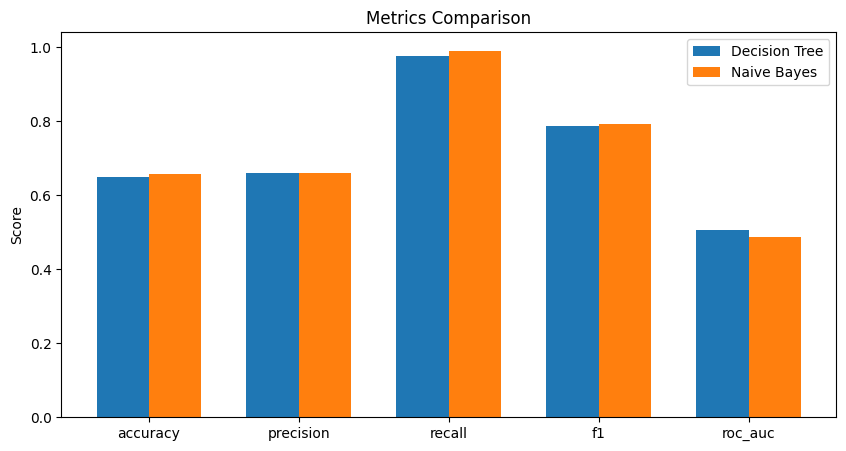

In [23]:
# Comparison graphs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Bar chart of metrics
metrics_names = ['accuracy','precision','recall','f1','roc_auc']
dt_values = [dt_metrics[m] for m in metrics_names]
nb_values = [nb_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x - width/2, dt_values, width, label='Decision Tree')
ax.bar(x + width/2, nb_values, width, label='Naive Bayes')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.set_ylabel('Score')
ax.set_title('Metrics Comparison')
ax.legend()
plt.show()

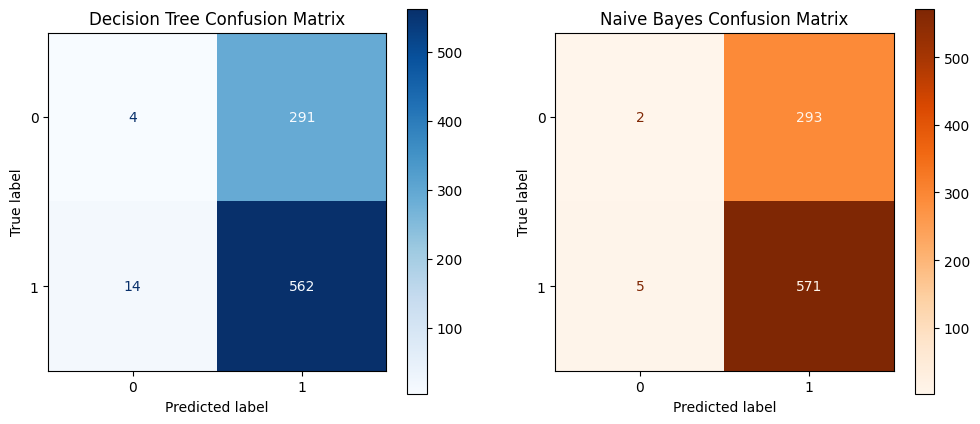

In [24]:
# Confusion matrices
fig, axes = plt.subplots(1,2, figsize=(12,5))
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, ax=axes[0], cmap='Blues')
axes[0].set_title('Decision Tree Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(nb, X_test, y_test, ax=axes[1], cmap='Oranges')
axes[1].set_title('Naive Bayes Confusion Matrix')
plt.show()

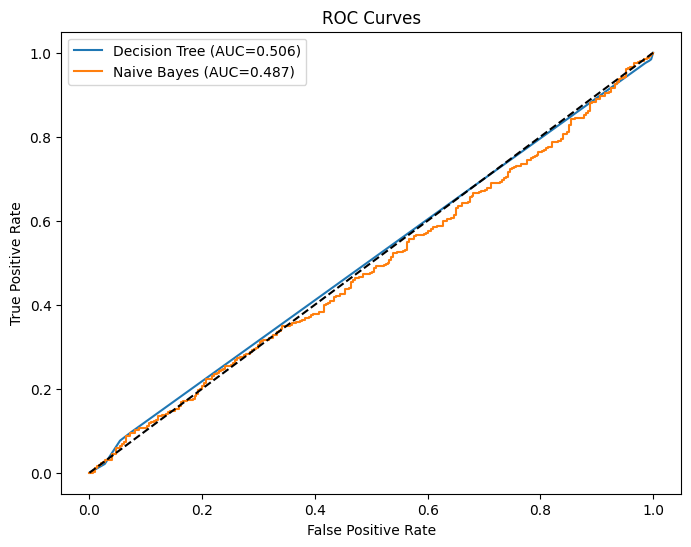

In [25]:
# ROC Curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, p_dt)
fpr_nb, tpr_nb, _ = roc_curve(y_test, p_nb)
plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC={dt_metrics["roc_auc"]})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC={nb_metrics["roc_auc"]})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

/tmp/ipython-input-3192012851.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')


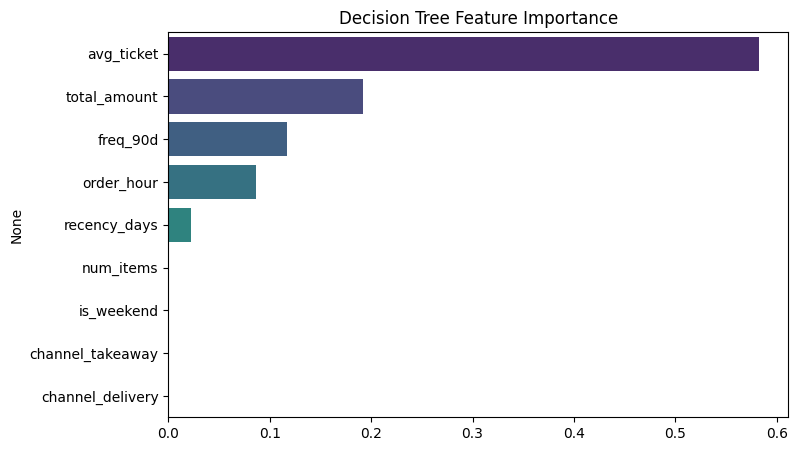

In [26]:
# Decision Tree Feature Importance
feat_imp = pd.Series(dt.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title('Decision Tree Feature Importance')
plt.show()

In [30]:
# Naive Bayes Feature mean/variance table
nb_summary = pd.DataFrame({
    'Feature': feature_cols,
    'Mean_Class0': nb.theta_[0],
    'Mean_Class1': nb.theta_[1],
    'Var_Class0': nb.var_[0],
    'Var_Class1': nb.var_[1]
})
nb_summary

,Feature,Mean_Class0,Mean_Class1,Var_Class0,Var_Class1
0,total_amount,1055.497592,1062.065000,267161.732578,272268.093891
1,num_items,4.530612,4.567647,5.228926,5.483930
2,recency_days,127.000000,134.425000,94518.628842,101349.944646
3,avg_ticket,365.056725,361.038507,159355.293230,138175.634333
4,order_hour,16.171429,15.960294,13.750475,13.629577
5,is_weekend,0.297959,0.311765,0.209450,0.214838
6,freq_90d,2.918367,2.973529,5.193607,5.164276
7,channel_takeaway,0.216327,0.189706,0.169800,0.153988
8,channel_delivery,0.000000,0.000000,0.000271,0.000271


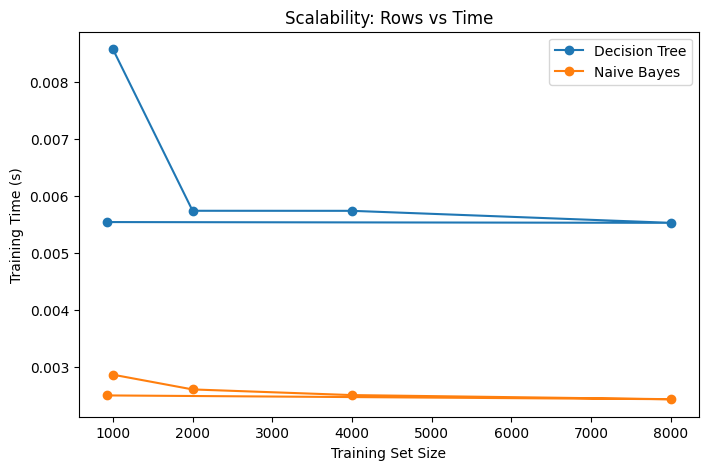

In [29]:
# Data Mining Scalability
import time
sizes = [1000,2000,4000,8000,len(X_train)]
dt_times, nb_times = [], []
for s in sizes:
    Xs, ys = X_train[:s], y_train[:s]
    t0 = time.time(); DecisionTreeClassifier(max_depth=6).fit(Xs,ys); dt_times.append(time.time()-t0)
    t0 = time.time(); GaussianNB().fit(Xs,ys); nb_times.append(time.time()-t0)
plt.figure(figsize=(8,5))
plt.plot(sizes, dt_times, 'o-', label='Decision Tree')
plt.plot(sizes, nb_times, 'o-', label='Naive Bayes')
plt.xlabel('Training Set Size')
plt.ylabel('Training Time (s)')
plt.title('Scalability: Rows vs Time')
plt.legend()
plt.show()

In [ ]:
# Data Mining Scalability
{
  "cell_type": "code",
  "metadata": {},
  "source": [
    "# Feature Scalability Test (duplicate columns)\n",
    "feat_counts = [len(feature_cols), len(feature_cols)*2, len(feature_cols)*4]\n",
    "dt_feat_times, nb_feat_times = [], []\n",
    "\n",
    "for f in feat_counts:\n",
    "    Xf = pd.concat([X_train]*int(f/len(feature_cols)), axis=1)\n",
    "    t0 = time.time(); DecisionTreeClassifier(max_depth=6).fit(Xf, y_train); dt_feat_times.append(time.time()-t0)\n",
    "    t0 = time.time(); GaussianNB().fit(Xf, y_train); nb_feat_times.append(time.time()-t0)\n",
    "\n",
    "# Plot Training Time vs Features\n",
    "plt.figure(figsize=(8,5))\n",
    "plt.plot(feat_counts, dt_feat_times, 'o-', label='Decision Tree')\n",
    "plt.plot(feat_counts, nb_feat_times, 'o-', label='Naive Bayes')\n",
    "plt.xlabel('Number of Features')\n",
    "plt.ylabel('Training Time (s)')\n",
    "plt.title('Scalability: Features vs Training Time')\n",
    "plt.legend()\n",
    "plt.show()\n",
    "\n",
    "# Combined Rows & Features Scalability Comparison\n",
    "fig, axes = plt.subplots(1,2, figsize=(14,5))\n",
    "axes[0].plot(sizes, dt_times, 'o-', label='Decision Tree')\n",
    "axes[0].plot(sizes, nb_times, 'o-', label='Naive Bayes')\n",
    "axes[0].set_title('Training Time vs Rows')\n",
    "axes[0].set_xlabel('Rows')\n",
    "axes[0].set_ylabel('Time (s)')\n",
    "axes[0].legend()\n",
    "\n",
    "axes[1].plot(feat_counts, dt_feat_times, 'o-', label='Decision Tree')\n",
    "axes[1].plot(feat_counts, nb_feat_times, 'o-', label='Naive Bayes')\n",
    "axes[1].set_title('Training Time vs Features')\n",
    "axes[1].set_xlabel('Number of Features')\n",
    "axes[1].set_ylabel('Time (s)')\n",
    "axes[1].legend()\n",
    "\n",
    "plt.suptitle('Scalability Comparison: Decision Tree vs Naive Bayes')\n",
    "plt.show()"
  ]
}
